# 2025 Fantasy Transaction Analysis

**Three questions:**
1. What proportion of each team's value came from the **draft**, **FA pickups**, and **trades**?
2. **Who won each trade?** (based on actual post-trade player performance)
3. Which teams had the most / least **draft surplus value**?

**Methodology:**
- Actual player z-scores use the 2025 preseason projection pool (players with z>0 in `players2025`) as the baseline mean/std.
- Z-scores are then shifted by replacement level (the z-score of the 168th-ranked hitter / 108th-ranked pitcher) so that above-replacement players have positive value.
- Dollar values use the same $/z conversion as preseason projections (~$5/z scaled to the actual season).
- Rate stats (BA, ERA, WHIP) are weighted by AB/IP volume.
- For Q1, each player's full-season value is pro-rated by weeks spent on each team.

In [1]:
import sqlite3
import pandas as pd
import numpy as np
import ast
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import warnings
warnings.filterwarnings('ignore')

conn = sqlite3.connect('fantasy_data.db')

N_TEAMS         = 12
TM_DOLLARS      = 260
REPL_HITTERS    = N_TEAMS * 14   # 168 — replacement-level rank for hitters
REPL_PITCHERS   = N_TEAMS * 9    # 108 — replacement-level rank for pitchers
HITTER_POS = {'C', '1B', '2B', '3B', 'SS', 'OF', 'DH', 'MI', 'CI'}
STAT_COLS  = ['R', 'RBI', 'HR', 'SB', 'H', 'AB', 'SO', 'SvHld', 'ER', 'Ha', 'BBa', 'IP', 'outs', 'QS']

# ── Owner name standardisation ────────────────────────────────────────────────
# players2025 uses short names; roster/adds/trades use various long names.
# Map everything to owner_id, then display using the owners table name.
P25_TO_OID = {
    '9 Grand Kids': 30, 'Brewbirds': 3,  'Charmer': 36,  'Dirty Birds': 41,
    'Harvey': 4,         'Lima Time': 38, 'Mother': 47,   'Roid Ragers': 44,
    'Trouble': 1,        'Ugly Spuds': 29,'Wu-Tang': 42,  'Young Guns': 45,
}
CSV_TO_OID = {
    '9 Grand Kids': 30,  'Brewbirds': 3,  'Charmer': 36,  'Dirty Birds': 41,
    'Harveys Wallbangers': 4,   'Lil Trumps Wiscompton Wu-Tang': 42,
    'Lima Time!': 38,           "Mom's Cookin": 47,
    'Roid Ragers': 44,          'Trouble With The Curve': 1,
    'Trouble with the Curve': 1,'Ugly Spuds': 29, 'Young Guns': 45,
}

## 1 · Load data

In [2]:
# ── Preseason projections ─────────────────────────────────────────────────────
all_proj = pd.read_sql("""
    SELECT CAST(cbsid AS INT) cbsid, Name, Primary_Pos, z, Value,
           AB, R, HR, RBI, SB, H, IP, ERA, WHIP, SO, QS, SvHld, ER, HA, BB
    FROM players2025
""", conn)
all_proj['ptype'] = all_proj['Primary_Pos'].apply(
    lambda x: 'h' if pd.notna(x) and x in HITTER_POS else 'p'
)

# Owned players (final 2025 rosters) — standardise owner name → owner_id
owned_raw = pd.read_sql("""
    SELECT CAST(cbsid AS INT) cbsid, Name, Pos, Primary_Pos, Owner, Paid, Supp, Value, z
    FROM players2025
    WHERE Owner IS NOT NULL
""", conn)
owned_raw['owner_id'] = owned_raw['Owner'].map(P25_TO_OID)
owned_raw['ptype'] = owned_raw['Primary_Pos'].apply(
    lambda x: 'h' if pd.notna(x) and x in HITTER_POS else 'p'
)

# ── Owner lookup ──────────────────────────────────────────────────────────────
owners_df = pd.read_sql('SELECT owner_id, owner FROM owners', conn)
OID_TO_NAME = dict(zip(owners_df['owner_id'], owners_df['owner']))

# ── Roster assignments (2025) — attach canonical owner name ──────────────────
roster = pd.read_sql('SELECT cbsid, owner_id, week FROM roster WHERE year=2025', conn)
roster['owner'] = roster['owner_id'].map(OID_TO_NAME)

# ── Weekly stats ──────────────────────────────────────────────────────────────
stats = pd.read_sql("""
    SELECT cbsid, week, R, RBI, HR, SB, H, AB, SO, SvHld, ER, Ha, BBa, IP, outs, QS
    FROM stats WHERE year=2025
""", conn)

# ── Transaction CSVs — standardise owner names ────────────────────────────────
adds = pd.read_csv('2025-adds.csv')
adds['owner_id'] = adds['owner'].map(CSV_TO_OID)
adds['owner_std'] = adds['owner_id'].map(OID_TO_NAME)

trades = pd.read_csv('2025-trades.csv')
trades['owner_id'] = trades['owner'].map(CSV_TO_OID)
trades['owner_std'] = trades['owner_id'].map(OID_TO_NAME)

p_meta = all_proj[['cbsid', 'Name', 'Primary_Pos', 'ptype']].drop_duplicates('cbsid')

print(f"Owned players: {len(owned_raw)} | Roster rows: {len(roster)}")
print(f"Distinct owners in roster: {roster['owner_id'].nunique()}")
print(f"Owner ids in roster: {sorted(roster['owner_id'].unique())}")

Owned players: 397 | Roster rows: 11103
Distinct owners in roster: 12
Owner ids in roster: [np.int64(1), np.int64(3), np.int64(4), np.int64(29), np.int64(30), np.int64(36), np.int64(38), np.int64(41), np.int64(42), np.int64(44), np.int64(45), np.int64(47)]


## 2 · Build projected baseline & z-score functions

In [3]:
h_proj = all_proj[(all_proj['ptype'] == 'h') & (all_proj['z'] > 0)].copy()
p_proj = all_proj[(all_proj['ptype'] == 'p') & (all_proj['z'] > 0)].copy()

h_proj['BA'] = h_proj['H'] / h_proj['AB'].replace(0, np.nan)
p_proj['ERA_indiv']  = p_proj['ER']  / p_proj['IP'].replace(0, np.nan) * 9
p_proj['WHIP_indiv'] = (p_proj['HA'] + p_proj['BB']) / p_proj['IP'].replace(0, np.nan)

PROJ_MEANS_H   = {c: h_proj[c].mean() for c in ['R', 'HR', 'RBI', 'SB']}
PROJ_STDS_H    = {c: h_proj[c].std()  for c in ['R', 'HR', 'RBI', 'SB']}
PROJ_BA_MEAN   = h_proj['H'].sum() / h_proj['AB'].sum()
PROJ_BA_STD    = h_proj['BA'].std()
PROJ_AVG_AB    = h_proj['AB'].mean()
PROJ_MEANS_P   = {c: p_proj[c].mean() for c in ['SO', 'QS', 'SvHld']}
PROJ_STDS_P    = {c: p_proj[c].std()  for c in ['SO', 'QS', 'SvHld']}
PROJ_ERA_MEAN  = p_proj['ER'].sum() / p_proj['IP'].sum() * 9
PROJ_ERA_STD   = p_proj['ERA_indiv'].std()
PROJ_WHIP_MEAN = (p_proj['HA'].sum() + p_proj['BB'].sum()) / p_proj['IP'].sum()
PROJ_WHIP_STD  = p_proj['WHIP_indiv'].std()
PROJ_AVG_IP    = p_proj['IP'].mean()

print(f"Pool: {len(h_proj)} hitters, {len(p_proj)} pitchers")
print(f"Hitter baseline — avg AB: {PROJ_AVG_AB:.0f}, avg R: {PROJ_MEANS_H['R']:.1f}, avg HR: {PROJ_MEANS_H['HR']:.1f}")
print(f"Pitcher baseline — avg IP: {PROJ_AVG_IP:.0f}, ERA: {PROJ_ERA_MEAN:.2f}, WHIP: {PROJ_WHIP_MEAN:.3f}")


def compute_raw_z(df: pd.DataFrame) -> pd.Series:
    """Compute z-score using projected pool as baseline. Returns raw (unshifted) z."""
    z = pd.DataFrame(index=df.index, dtype=float)
    ptype = df['ptype'].copy()
    # Two-way / misclassified pitcher with batting stats → treat as hitter
    reclassify = (ptype == 'p') & (df['IP'].fillna(0) < 5) & (df['AB'].fillna(0) >= 50)
    ptype[reclassify] = 'h'

    h_mask, p_mask = ptype == 'h', ptype == 'p'
    if h_mask.any():
        hdf = df[h_mask]
        for cat in ['R', 'HR', 'RBI', 'SB']:
            z.loc[h_mask, f'z{cat}'] = (hdf[cat] - PROJ_MEANS_H[cat]) / PROJ_STDS_H[cat]
        df_ba = hdf['H'] / hdf['AB'].replace(0, np.nan)
        z.loc[h_mask, 'zBA'] = (df_ba - PROJ_BA_MEAN) / PROJ_BA_STD * (hdf['AB'] / PROJ_AVG_AB)
    if p_mask.any():
        pdf = df[p_mask]
        for cat in ['SO', 'QS', 'SvHld']:
            z.loc[p_mask, f'z{cat}'] = (pdf[cat] - PROJ_MEANS_P[cat]) / PROJ_STDS_P[cat]
        df_era  = pdf['ER'] / pdf['IP'].replace(0, np.nan) * 9
        z.loc[p_mask, 'zERA']  = -(df_era  - PROJ_ERA_MEAN)  / PROJ_ERA_STD  * (pdf['IP'] / PROJ_AVG_IP)
        df_whip = (pdf['Ha'] + pdf['BBa']) / pdf['IP'].replace(0, np.nan)
        z.loc[p_mask, 'zWHIP'] = -(df_whip - PROJ_WHIP_MEAN) / PROJ_WHIP_STD * (pdf['IP'] / PROJ_AVG_IP)
    return z.fillna(0).sum(axis=1)

Pool: 154 hitters, 111 pitchers
Hitter baseline — avg AB: 496, avg R: 73.2, avg HR: 21.7
Pitcher baseline — avg IP: 127, ERA: 3.45, WHIP: 1.147


## 3 · Compute actual z-scores with replacement-level adjustment

In [4]:
# ── Full-season stats per player ──────────────────────────────────────────────
season_totals = stats.groupby('cbsid')[STAT_COLS].sum(min_count=1).reset_index()
season_totals = season_totals.merge(p_meta, on='cbsid', how='left')
season_totals['raw_z'] = compute_raw_z(season_totals)

# ── Replacement-level shift ──────────────────────────────────────────────────
# Shift hitter and pitcher z-scores so that the REPL_HITTERS-th (168th) and
# REPL_PITCHERS-th (108th) ranked players sit at z=0 (i.e., worth $0).
hz = season_totals[season_totals['ptype'] == 'h']['raw_z'].sort_values(ascending=False)
pz = season_totals[season_totals['ptype'] == 'p']['raw_z'].sort_values(ascending=False)

repl_z_h = hz.iloc[REPL_HITTERS - 1]  if len(hz) >= REPL_HITTERS  else hz.min()
repl_z_p = pz.iloc[REPL_PITCHERS - 1] if len(pz) >= REPL_PITCHERS else pz.min()

print(f"Replacement level z — hitter: {repl_z_h:.2f}, pitcher: {repl_z_p:.2f}")

def apply_repl_shift(df: pd.DataFrame, raw_z_col='raw_z') -> pd.Series:
    """Apply the replacement-level shift so z=0 → replacement level."""
    ptype = df['ptype'].fillna('p')
    shift = ptype.map({'h': repl_z_h, 'p': repl_z_p}).fillna(repl_z_p)
    return df[raw_z_col] - shift

season_totals['actual_z'] = apply_repl_shift(season_totals)

# ── Dollar conversion ─────────────────────────────────────────────────────────
total_pos_z = season_totals[season_totals['actual_z'] > 0]['actual_z'].sum()
CONV = TM_DOLLARS * N_TEAMS / total_pos_z
season_totals['actual_value'] = season_totals['actual_z'] * CONV

print(f"Total positive z: {total_pos_z:.1f} | $/z: {CONV:.2f}")
print(f"Players with positive actual value: {(season_totals['actual_z']>0).sum()}")
print()
print("Top 20 by actual value:")
print(season_totals.nlargest(20, 'actual_value')[
    ['Name', 'ptype', 'raw_z', 'actual_z', 'actual_value']
].round(1).to_string(index=False))

Replacement level z — hitter: -5.27, pitcher: -1.73
Total positive z: 1663.1 | $/z: 1.88
Players with positive actual value: 543

Top 20 by actual value:
            Name ptype  raw_z  actual_z  actual_value
     Aaron Judge     h   16.8      22.1          41.4
       Juan Soto     h   11.6      16.8          31.6
   Shohei Ohtani     p   14.7      16.4          30.8
     Cal Raleigh     h   11.1      16.4          30.7
  Kyle Schwarber     h   10.5      15.7          29.5
    Jose Ramirez     h    8.8      14.1          26.4
    Tarik Skubal     p   12.2      13.9          26.1
  Bobby Witt Jr.     h    8.1      13.3          25.0
 George Springer     h    8.0      13.2          24.8
 Julio Rodriguez     h    7.9      13.2          24.8
Francisco Lindor     h    7.6      12.9          24.2
     Paul Skenes     p   10.9      12.7          23.8
 Junior Caminero     h    7.2      12.5          23.4
     Pete Alonso     h    7.0      12.2          23.0
 Geraldo Perdomo     h    6.9      1

In [5]:
# Cross-check a few known players against their preseason projections
check_ids = [2071264, 3117472, 2044495, 2507367, 2901324]  # Judge, BWJ, JRam, Soto, Ohtani
comp = owned_raw[owned_raw['cbsid'].isin(check_ids)][['cbsid','Name','Owner','Paid','Value','z']].copy()
comp = comp.merge(season_totals[['cbsid','actual_z','actual_value']].round(1), on='cbsid', how='left')
comp['proj_value'] = comp['z'] * (TM_DOLLARS * N_TEAMS / all_proj[all_proj['z']>0]['z'].sum())
print("Projected vs Actual (key players):")
print(comp[['Name','Owner','Paid','proj_value','actual_value']].round(1).to_string(index=False))

Projected vs Actual (key players):
          Name       Owner  Paid  proj_value  actual_value
 Shohei Ohtani     Charmer    41        61.0          30.8
   Aaron Judge Roid Ragers    34        54.1          41.4
Bobby Witt Jr.     Charmer    48        50.5          25.0
  Jose Ramirez      Mother    39        43.2          26.4
     Juan Soto     Trouble    37        40.4          31.6


## 4 · Classify acquisition source

In [6]:
# ── First week each player appeared on each team ──────────────────────────────
first_week = (
    roster.groupby(['cbsid', 'owner_id'])['week'].min().reset_index()
    .rename(columns={'week': 'first_week'})
)

# ── Parse trades CSV → (cbsid, receiving owner_id) pairs ─────────────────────
pname_map = pd.read_sql("""
    SELECT CAST(cbsid AS INT) cbsid, Name FROM players2025
    UNION
    SELECT CAST(cbsid AS INT) cbsid, CBSNAME AS Name FROM players
""", conn).drop_duplicates('Name')

trade_records = []
for _, row in trades.iterrows():
    oid_recv = row['owner_id']
    oid_send = CSV_TO_OID.get(str(row['parsed_transactions']), None)  # fallback
    for p in ast.literal_eval(row['parsed_transactions']):
        send_oid = CSV_TO_OID.get(p['Trade_Partner'], None)
        trade_records.append({
            'effective':   row['Effective'],
            'period':      int(row['period']),
            'recv_oid':    int(oid_recv),
            'send_oid':    send_oid,
            'receiver':    OID_TO_NAME.get(int(oid_recv), str(oid_recv)),
            'sender':      OID_TO_NAME.get(send_oid, p['Trade_Partner']) if send_oid else p['Trade_Partner'],
            'player_name': p['Name'],
            'cbsid_csv':   int(row['cbsid']),
        })

trade_df = pd.DataFrame(trade_records)
trade_df = trade_df.merge(
    pname_map.rename(columns={'cbsid': 'cbsid_lookup', 'Name': 'player_name'}),
    on='player_name', how='left'
)
# Use name-matched cbsid where available, else fall back to CSV cbsid
trade_df['cbsid'] = trade_df['cbsid_lookup'].combine_first(
    trade_df['cbsid_csv'].astype('float')
).astype('Int64')

# Set of (cbsid, recv_oid) for traded players
traded_pairs = set(zip(trade_df['cbsid'].dropna().astype(int), trade_df['recv_oid'].astype(int)))

# Set of (cbsid, owner_id) for FA adds
fa_pairs = set(zip(adds['cbsid'], adds['owner_id'].astype(int)))

def classify_acq(cbsid, owner_id, first_week):
    if first_week == 1:                      return 'Draft'
    if (int(cbsid), int(owner_id)) in traded_pairs: return 'Trade'
    return 'FA'

# ── Pro-rate full-season value by weeks on each team ─────────────────────────
weeks_per_team = (
    roster.groupby(['cbsid', 'owner_id'])
    .agg(weeks=('week', 'count')).reset_index()
)
total_weeks = (
    roster.groupby('cbsid')['week'].count().reset_index()
    .rename(columns={'week': 'total_weeks'})
)
wk = weeks_per_team.merge(total_weeks, on='cbsid')
wk['fraction'] = wk['weeks'] / wk['total_weeks']
wk['owner']    = wk['owner_id'].map(OID_TO_NAME)
wk = wk.merge(season_totals[['cbsid', 'Name', 'ptype', 'actual_z', 'actual_value']], on='cbsid', how='left')
wk['team_value'] = wk['actual_value'] * wk['fraction']

wk = wk.merge(first_week, on=['cbsid', 'owner_id'], how='left')
wk['source'] = wk.apply(
    lambda r: classify_acq(r['cbsid'], r['owner_id'], r['first_week']), axis=1
)

print("Acquisition counts:")
print(wk['source'].value_counts())
print("\nSample player-team classifications:")
print(wk[['Name', 'owner', 'weeks', 'fraction', 'first_week', 'source', 'team_value']]
      .query("team_value > 5").head(10).round(1).to_string(index=False))

Acquisition counts:
source
Draft    396
FA       223
Trade     50
Name: count, dtype: int64

Sample player-team classifications:
            Name               owner  weeks  fraction  first_week source  team_value
 Freddie Freeman          Ugly Spuds     13       0.5          16  Trade         7.9
 Freddie Freeman  Wiscompton Wu-Tang     15       0.5           1  Draft         9.1
 Aroldis Chapman           Brewbirds     28       1.0           1  Draft        11.1
    Zack Wheeler           Brewbirds     24       1.0           1  Draft        15.5
      Chris Sale           Brewbirds     28       1.0           1  Draft         9.2
   Manny Machado         Dirty Birds     28       1.0           1  Draft        18.8
    Bryce Harper        Mom's Cookin     28       1.0           1  Draft        11.2
Christian Yelich Harveys Wallbangers     13       0.5          16  Trade         8.8
Christian Yelich          Lima Time!     15       0.5           1  Draft        10.1
Nick Castellanos     

## 5 · Q1 — Value by acquisition source

In [7]:
q1 = (
    wk.groupby(['owner', 'source'])['team_value']
    .sum().unstack(fill_value=0).round(1)
)
for col in ['Draft', 'FA', 'Trade']:
    if col not in q1.columns:
        q1[col] = 0.0

# Use only positive contributions for proportion (avoids divide-by-zero if total<0)
q1['Total'] = q1[['Draft', 'FA', 'Trade']].sum(axis=1)
pos_total   = q1[['Draft', 'FA', 'Trade']].clip(lower=0).sum(axis=1).replace(0, np.nan)
for col in ['Draft', 'FA', 'Trade']:
    q1[f'{col}%'] = (q1[col].clip(lower=0) / pos_total * 100).fillna(0).round(1)

q1_display = q1[['Total', 'Draft', 'Draft%', 'FA', 'FA%', 'Trade', 'Trade%']]\
    .sort_values('Total', ascending=False)
print("=== VALUE BY ACQUISITION SOURCE ===\n")
print(q1_display.to_string())

=== VALUE BY ACQUISITION SOURCE ===

source                  Total  Draft  Draft%     FA   FA%  Trade  Trade%
owner                                                                   
Harveys Wallbangers     147.3  136.6    87.6   -8.7   0.0   19.4    12.4
Brewbirds                83.9  125.0   100.0  -19.5   0.0  -21.6     0.0
Trouble with the Curve   68.1   55.8    80.9   -0.9   0.0   13.2    19.1
Young Guns               50.7   41.8    82.4    8.9  17.6    0.0     0.0
Lima Time!               18.5   30.5    98.1  -12.6   0.0    0.6     1.9
Charmer                 -18.8   75.9    90.8 -102.4   0.0    7.7     9.2
Ugly Spuds              -24.7   26.8    64.7  -66.1   0.0   14.6    35.3
Dirty Birds             -29.1   -5.5     0.0  -29.7   0.0    6.1   100.0
Roid Ragers             -35.6    5.1   100.0  -40.7   0.0    0.0     0.0
Wiscompton Wu-Tang      -36.0  -13.6     0.0  -38.5   0.0   16.1   100.0
9 Grand Kids            -65.1  -35.0     0.0  -29.5   0.0   -0.6     0.0
Mom's Cookin  

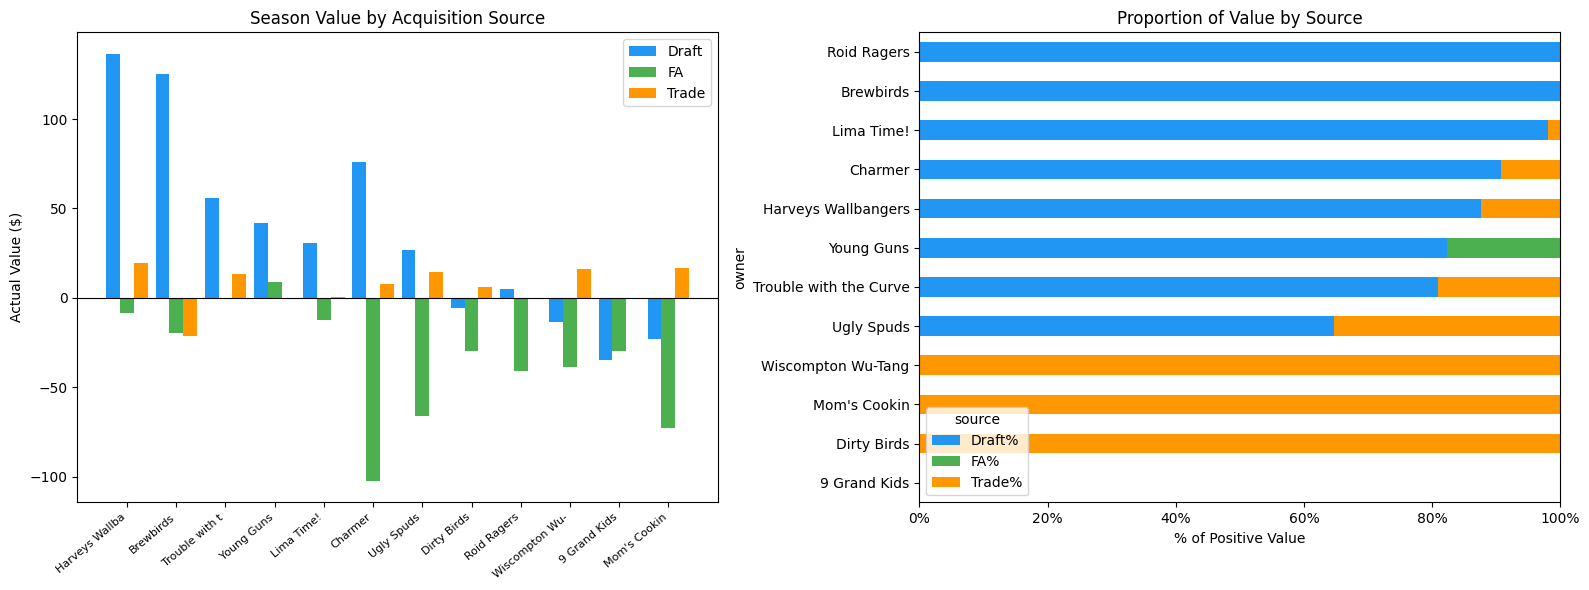

In [8]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6))
colors = {'Draft': '#2196F3', 'FA': '#4CAF50', 'Trade': '#FF9800'}

ax = axes[0]
owners_sorted = q1_display.index.tolist()
x, w = np.arange(len(owners_sorted)), 0.28
for i, src in enumerate(['Draft', 'FA', 'Trade']):
    ax.bar(x + (i-1)*w, q1_display[src], width=w, label=src, color=colors[src])
ax.set_xticks(x)
ax.set_xticklabels([o[:14] for o in owners_sorted], rotation=40, ha='right', fontsize=8)
ax.set_ylabel('Actual Value ($)')
ax.set_title('Season Value by Acquisition Source')
ax.axhline(0, color='black', linewidth=0.8)
ax.legend()

ax2 = axes[1]
q1_pct = q1[['Draft%', 'FA%', 'Trade%']].sort_values('Draft%', ascending=True)
q1_pct.plot.barh(stacked=True, ax=ax2,
    color=[colors['Draft'], colors['FA'], colors['Trade']])
ax2.set_xlabel('% of Positive Value')
ax2.set_title('Proportion of Value by Source')
ax2.xaxis.set_major_formatter(mticker.PercentFormatter())

plt.tight_layout()
plt.show()

## 6 · Q2 — Who won each trade?
For each trade: actual value each team received from their incoming players, from the trade-effective week onward.

In [9]:
# ── Group individual player rows into distinct trade events ───────────────────
trade_df['team_pair'] = trade_df.apply(
    lambda r: tuple(sorted([str(r['recv_oid']), str(r.get('send_oid', ''))])), axis=1
)
unique_trades = (
    trade_df[['effective', 'period', 'team_pair']].drop_duplicates()
    .sort_values('effective').reset_index(drop=True)
)
unique_trades['trade_id'] = [f'T{i+1:02d}' for i in range(len(unique_trades))]
trade_df = trade_df.merge(unique_trades, on=['effective', 'period', 'team_pair'], how='left')

print(f"Distinct trades: {unique_trades['trade_id'].nunique()}")
print(unique_trades[['trade_id', 'effective', 'period', 'team_pair']].to_string(index=False))

Distinct trades: 12
trade_id effective  period team_pair
     T01   3/24/25       1   (3, 47)
     T02   4/14/25       4   (4, 42)
     T03   4/14/25       4   (1, 47)
     T04   5/12/25       8   (4, 42)
     T05   5/19/25       9  (38, 47)
     T06   5/26/25      10    (1, 4)
     T07   5/26/25      10  (36, 42)
     T08   6/23/25      14  (36, 42)
     T09   6/30/25      15   (38, 4)
     T10   6/30/25      15  (29, 42)
     T11   7/14/25      17   (4, 41)
     T12   8/11/25      21   (1, 30)


In [10]:
# ── Compute post-trade value for each received player ─────────────────────────
rs = roster.merge(stats, on=['cbsid', 'week'], how='left')  # roster × stats

trade_results = []
for _, trow in trade_df.dropna(subset=['cbsid']).iterrows():
    cbsid    = int(trow['cbsid'])
    recv_oid = int(trow['recv_oid'])
    period   = int(trow['period'])
    trade_id = trow['trade_id']

    mask = (rs['cbsid'] == cbsid) & (rs['owner_id'] == recv_oid) & (rs['week'] >= period)
    post_s = rs[mask][STAT_COLS].sum()

    pm = p_meta[p_meta['cbsid'] == cbsid]
    ptype = pm['ptype'].iloc[0] if len(pm) else 'p'

    rdf = pd.DataFrame([post_s])
    rdf['ptype'] = ptype
    raw_z  = compute_raw_z(rdf).iloc[0]
    shift  = repl_z_h if ptype == 'h' else repl_z_p
    adj_z  = raw_z - shift
    value  = adj_z * CONV

    trade_results.append({
        'trade_id':  trade_id,
        'effective': trow['effective'],
        'period':    period,
        'recv_oid':  recv_oid,
        'receiver':  OID_TO_NAME.get(recv_oid, str(recv_oid)),
        'sender':    trow['sender'],
        'player':    trow['player_name'],
        'ptype':     ptype,
        'post_z':    round(adj_z, 2),
        'post_value':round(value, 1),
        'weeks_held': mask.sum(),
    })

trd = pd.DataFrame(trade_results)
print("Trade result rows:", len(trd))
print(trd[['trade_id','receiver','player','ptype','weeks_held','post_value']].head(12).to_string(index=False))

Trade result rows: 53
trade_id               receiver           player ptype  weeks_held  post_value
     T12           9 Grand Kids     Mitch Keller     p           7        -7.4
     T12 Trouble with the Curve        Will Vest     p           7        -5.6
     T11    Harveys Wallbangers  Julio Rodriguez     h          11         2.9
     T11    Harveys Wallbangers      Kirby Yates     p           7        -7.0
     T11            Dirty Birds     Heliot Ramos     h          11        -9.7
     T11            Dirty Birds      Nick Lodolo     p          11        -1.5
     T09    Harveys Wallbangers       Eury Perez     p           0        -6.2
     T09    Harveys Wallbangers Christian Yelich     h          13        -1.8
     T09    Harveys Wallbangers  Sandy Alcantara     p          13        -1.4
     T09             Lima Time!     Tommy Kahnle     p           3       -12.1
     T09             Lima Time!   Xavier Edwards     h          11        -6.7
     T09             Lima Time

In [11]:
# ── Summary per trade ─────────────────────────────────────────────────────────
tsum = (
    trd.groupby(['trade_id', 'effective', 'receiver'])
    .agg(players=('player', lambda x: ', '.join(x)),
         val=('post_value', 'sum'),
         z=('post_z', 'sum'))
    .reset_index()
    .sort_values(['trade_id', 'val'], ascending=[True, False])
)

print("=" * 95)
print("WHO WON EACH TRADE? — actual value received post-trade")
print("=" * 95)

for tid, grp in tsum.groupby('trade_id'):
    eff = grp['effective'].iloc[0]
    grp = grp.reset_index(drop=True)
    winner = grp.loc[grp['val'].idxmax(), 'receiver']
    print(f"\n{tid}  ({eff})")
    for _, r in grp.iterrows():
        tag = '  ◀ WINNER' if r['receiver'] == winner else ''
        print(f"  {r['receiver']:38s} received: {r['players']}")
        print(f"  {'':38s} value: ${r['val']:+.1f}  (z={r['z']:+.2f}){tag}")

print()
print("=== QUICK SCOREBOARD ===")
print(f"{'':6s}  {'Date':10s}  {'Team A':34s}  {'Team B':34s}  {'Winner'}")
print("-" * 105)
for tid, grp in tsum.groupby('trade_id'):
    eff = grp['effective'].iloc[0]
    rows = grp.sort_values('val', ascending=False).reset_index(drop=True)
    winner = rows.loc[0, 'receiver']
    if len(rows) >= 2:
        a = f"{rows.loc[0,'receiver'][:18]} (${rows.loc[0,'val']:+.1f})"
        b = f"{rows.loc[1,'receiver'][:18]} (${rows.loc[1,'val']:+.1f})"
        print(f"{tid:6s}  {eff:10s}  {a:34s}  {b:34s}  {winner[:14]}")

WHO WON EACH TRADE? — actual value received post-trade

T01  (3/24/25)
  Brewbirds                              received: David Hamilton, Erick Fedde
                                         value: $-25.7  (z=-13.71)  ◀ WINNER
  Mom's Cookin                           received: Nolan Jones, Dean Kremer
                                         value: $-27.4  (z=-14.61)

T02  (4/14/25)
  Harveys Wallbangers                    received: Joshua Lowe, Liam Hendriks, Brandon Woodruff
                                         value: $-7.7  (z=-4.13)  ◀ WINNER
  Wiscompton Wu-Tang                     received: Royce Lewis, Max Muncy, Nate Lowe
                                         value: $-34.7  (z=-18.55)

T03  (4/14/25)
  Mom's Cookin                           received: Kris Bubic, Ian Happ
                                         value: $+7.3  (z=+3.92)  ◀ WINNER
  Trouble with the Curve                 received: Merrill Kelly, Aaron Nola
                                         value: $-0

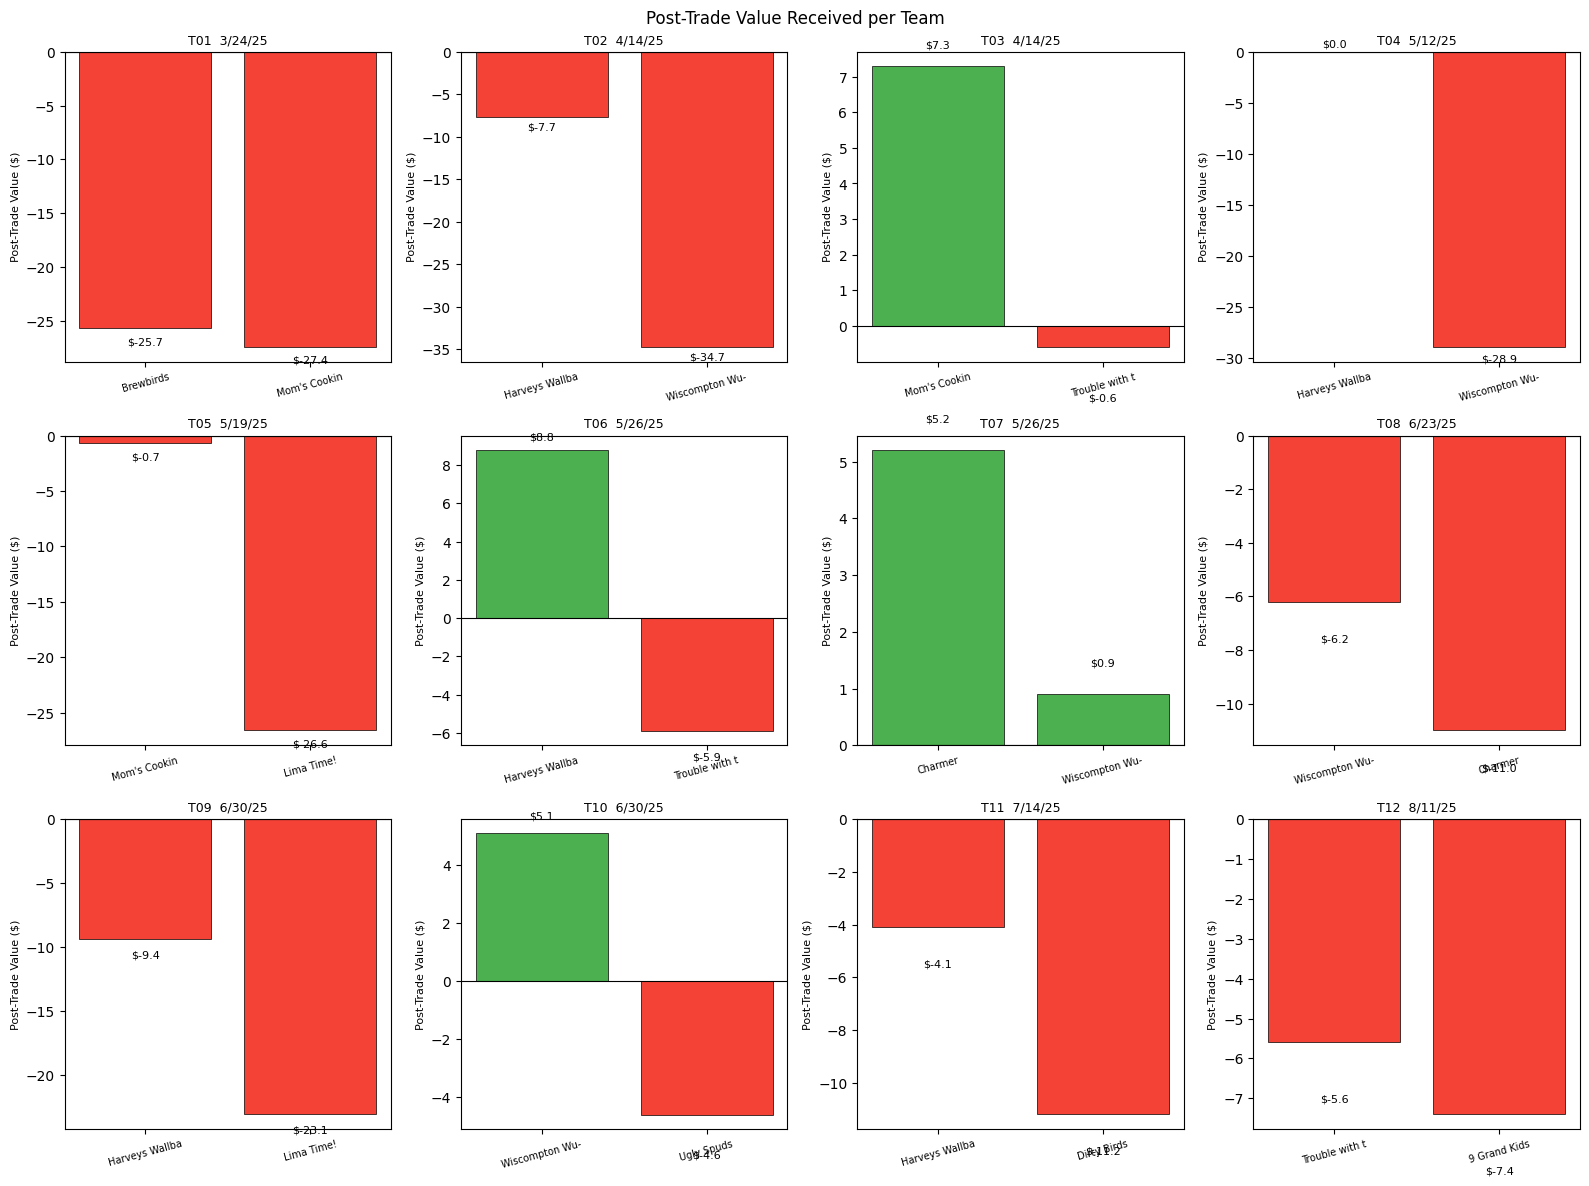

In [12]:
# ── Trade chart ───────────────────────────────────────────────────────────────
trade_ids = list(tsum['trade_id'].unique())
n = len(trade_ids)
ncols = 4
nrows = (n + ncols - 1) // ncols

fig, axes = plt.subplots(nrows, ncols, figsize=(16, 4 * nrows))
axes_flat = axes.flatten()

for i, tid in enumerate(trade_ids):
    ax = axes_flat[i]
    grp = tsum[tsum['trade_id'] == tid].reset_index(drop=True)
    eff = grp['effective'].iloc[0]
    vals   = grp['val'].tolist()
    labels = [r['receiver'][:14] for _, r in grp.iterrows()]
    bar_c  = ['#4CAF50' if v >= 0 else '#F44336' for v in vals]
    ax.bar(labels, vals, color=bar_c, edgecolor='black', linewidth=0.5)
    ax.axhline(0, color='black', linewidth=0.8)
    ax.set_title(f"{tid}  {eff}", fontsize=9)
    ax.set_ylabel('Post-Trade Value ($)', fontsize=8)
    ax.tick_params(axis='x', labelsize=7, rotation=15)
    for j, (lbl, val) in enumerate(zip(labels, vals)):
        ax.text(j, val + (0.5 if val >= 0 else -1.5), f'${val:.1f}', ha='center', fontsize=8)

for i in range(len(trade_ids), len(axes_flat)):
    axes_flat[i].set_visible(False)

plt.suptitle('Post-Trade Value Received per Team', fontsize=12)
plt.tight_layout()
plt.show()

## 7 · Q3 — Draft surplus value
**Surplus = actual value produced while on original team − amount paid at auction**

Snake draft players (`Paid = 0`) contributed value for free; any positive value is surplus.

In [13]:
# Use owner_id to join players2025 with the per-player-team value table
drafted = owned_raw[['cbsid', 'Name', 'Pos', 'ptype', 'owner_id', 'Owner', 'Paid', 'Supp', 'Value', 'z']].copy()
drafted['draft_type'] = drafted['Paid'].apply(lambda p: 'Auction' if p > 0 else 'Snake')

# Draft value = the pro-rated actual value from the 'Draft' source
draft_actual = wk[wk['source'] == 'Draft'][['cbsid', 'owner_id', 'team_value']]

drafted = drafted.merge(draft_actual, on=['cbsid', 'owner_id'], how='left')
drafted['team_value'] = drafted['team_value'].fillna(0)
drafted['surplus'] = drafted['team_value'] - drafted['Paid']

# canonical display name
drafted['team_name'] = drafted['owner_id'].map(OID_TO_NAME)

team_draft = (
    drafted.groupby('team_name')
    .agg(n_auction=('Paid', lambda x: (x > 0).sum()),
         n_snake  =('Supp', lambda x: (x > 0).sum()),
         total_paid=('Paid', 'sum'),
         proj_value=('Value', 'sum'),
         act_value =('team_value', 'sum'),
         surplus   =('surplus', 'sum'))
    .round(1)
    .sort_values('surplus', ascending=False)
)

print("=== TEAM DRAFT SURPLUS (best → worst) ===\n")
print(team_draft.to_string())

=== TEAM DRAFT SURPLUS (best → worst) ===

                        n_auction  n_snake  total_paid  proj_value  act_value  surplus
team_name                                                                             
Harveys Wallbangers            23       10         260       127.7      136.6   -123.4
Brewbirds                      23       10         260       245.6      125.0   -135.0
Charmer                        23       10         260       201.2       75.9   -184.1
Trouble with the Curve         23       10         259       192.8       55.8   -203.2
Lima Time!                     23       10         239       206.7       30.5   -208.5
Young Guns                     23       10         251       173.7       41.8   -209.2
Ugly Spuds                     23       10         258       121.5       26.8   -231.2
Roid Ragers                    23       10         255       195.3        5.1   -249.9
Dirty Birds                    23       10         255       208.7       -5.5   -260.5


In [14]:
# ── Individual auction picks ───────────────────────────────────────────────────
auction = drafted[drafted['draft_type'] == 'Auction'].sort_values('surplus', ascending=False)

print("=== TOP 15 AUCTION SURPLUS PLAYERS ===\n")
t15 = auction.head(15)[['Name', 'team_name', 'Pos', 'Paid', 'team_value', 'surplus']].round(1).copy()
t15['surplus'] = t15['surplus'].apply(lambda x: f'+${x:.1f}')
print(t15.rename(columns={'team_name': 'Owner'}).to_string(index=False))

print("\n=== WORST 15 AUCTION BUSTS ===\n")
b15 = auction.tail(15).sort_values('surplus')[['Name', 'team_name', 'Pos', 'Paid', 'team_value', 'surplus']].round(1).copy()
b15['surplus'] = b15['surplus'].apply(lambda x: f'${x:.1f}')
print(b15.rename(columns={'team_name': 'Owner'}).to_string(index=False))

=== TOP 15 AUCTION SURPLUS PLAYERS ===

               Name               Owner   Pos  Paid  team_value surplus
    George Springer          Lima Time!    OF     4        24.8  +$20.8
        Cal Raleigh        Mom's Cookin     C    13        30.7  +$17.7
       Byron Buxton          Ugly Spuds    OF     5        20.6  +$15.6
     Kyle Schwarber Harveys Wallbangers    OF    15        29.5  +$14.5
      Maikel Garcia             Charmer 2B,3B     1        14.8  +$13.8
     Eugenio Suarez           Brewbirds    3B     7        20.2  +$13.2
         Yandy Diaz         Roid Ragers    1B     3        16.0  +$13.0
          Zach Neto          Ugly Spuds    SS     1        12.5  +$11.5
Pete Crow-Armstrong        9 Grand Kids    OF     9        20.0  +$11.0
     Nathan Eovaldi          Young Guns    SP     6        16.7  +$10.7
    Garrett Crochet          Lima Time!    SP    10        20.7  +$10.7
       Nick Pivetta         Roid Ragers RP,SP     5        15.1  +$10.1
    Aroldis Chapman     

In [15]:
# ── Snake draft picks ─────────────────────────────────────────────────────────
snake = drafted[drafted['draft_type'] == 'Snake'].sort_values('team_value', ascending=False)
print("=== TOP 10 SNAKE PICKS (by actual value — pick cost = $0) ===\n")
print(snake.head(10)[['Name', 'team_name', 'Pos', 'Supp', 'team_value']]
      .rename(columns={'team_name': 'Owner'}).round(1).to_string(index=False))
print("\n=== WORST 10 SNAKE PICKS ===\n")
print(snake.tail(10).sort_values('team_value')[
    ['Name', 'team_name', 'Pos', 'Supp', 'team_value']
].rename(columns={'team_name': 'Owner'}).round(1).to_string(index=False))

=== TOP 10 SNAKE PICKS (by actual value — pick cost = $0) ===

             Name                  Owner   Pos  Supp  team_value
     Trevor Story Trouble with the Curve    SS   1.0        19.8
     Brice Turang             Young Guns    2B   4.0        18.6
      Paul Skenes             Ugly Spuds    SP   1.0        12.7
Spencer Torkelson Trouble with the Curve    1B   9.0         9.6
      Abner Uribe    Harveys Wallbangers    RP  10.0         8.6
   Drew Rasmussen Trouble with the Curve RP,SP   7.0         7.9
   Hunter Goodman     Wiscompton Wu-Tang  C,OF   3.0         7.8
  Junior Caminero             Lima Time!    3B   1.0         7.5
   Gleyber Torres              Brewbirds    2B   6.0         6.9
  Jonathan Aranda    Harveys Wallbangers 1B,2B   6.0         5.6

=== WORST 10 SNAKE PICKS ===

                        Name              Owner   Pos  Supp  team_value
              Chase DeLauter         Ugly Spuds    OF   9.0       -19.0
                 Oliver Dunn         Ugly Spuds

In [16]:
# ── Per-team best / worst ─────────────────────────────────────────────────────
print("=== PER-TEAM BEST / WORST AUCTION PICKS ===\n")
for team, grp in auction.groupby('team_name'):
    grp_s = grp.sort_values('surplus', ascending=False)
    total_s = grp_s['surplus'].sum()
    best  = ', '.join(f"{r['Name']} (+${r['surplus']:.0f})" for _, r in grp_s.head(3).iterrows())
    worst = ', '.join(f"{r['Name']} (${r['surplus']:.0f})"  for _, r in grp_s.tail(3).iterrows())
    print(f"{team}  (auction surplus: ${total_s:.0f})")
    print(f"  Best : {best}")
    print(f"  Worst: {worst}")
    print()

=== PER-TEAM BEST / WORST AUCTION PICKS ===

9 Grand Kids  (auction surplus: $-241)
  Best : Pete Crow-Armstrong (+$11), Salvador Perez (+$3), Diego Castillo (+$2)
  Worst: Justin Steele ($-20), George Kirby ($-21), Lane Thomas ($-34)

Brewbirds  (auction surplus: $-118)
  Best : Eugenio Suarez (+$13), Aroldis Chapman (+$10), Nico Hoerner (+$8)
  Worst: Zack Wheeler ($-17), Kyle Tucker ($-22), Tyler Fitzgerald ($-22)

Charmer  (auction surplus: $-139)
  Best : Maikel Garcia (+$14), Taylor Ward (+$8), Bo Bichette (+$2)
  Worst: Fernando Tatis Jr. ($-13), Pablo Lopez ($-16), Bobby Witt Jr. ($-23)

Dirty Birds  (auction surplus: $-228)
  Best : Bryan Woo (+$9), Ivan Herrera (+$5), Robert Suarez (+$3)
  Worst: Esteury Ruiz ($-22), Adley Rutschman ($-27), Cole Ragans ($-29)

Harveys Wallbangers  (auction surplus: $-131)
  Best : Kyle Schwarber (+$14), Cristopher Sanchez (+$7), Vinnie Pasquantino (+$3)
  Worst: Michael Toglia ($-16), Bowden Francis ($-18), Jordan Westburg ($-19)

Lima Time! 

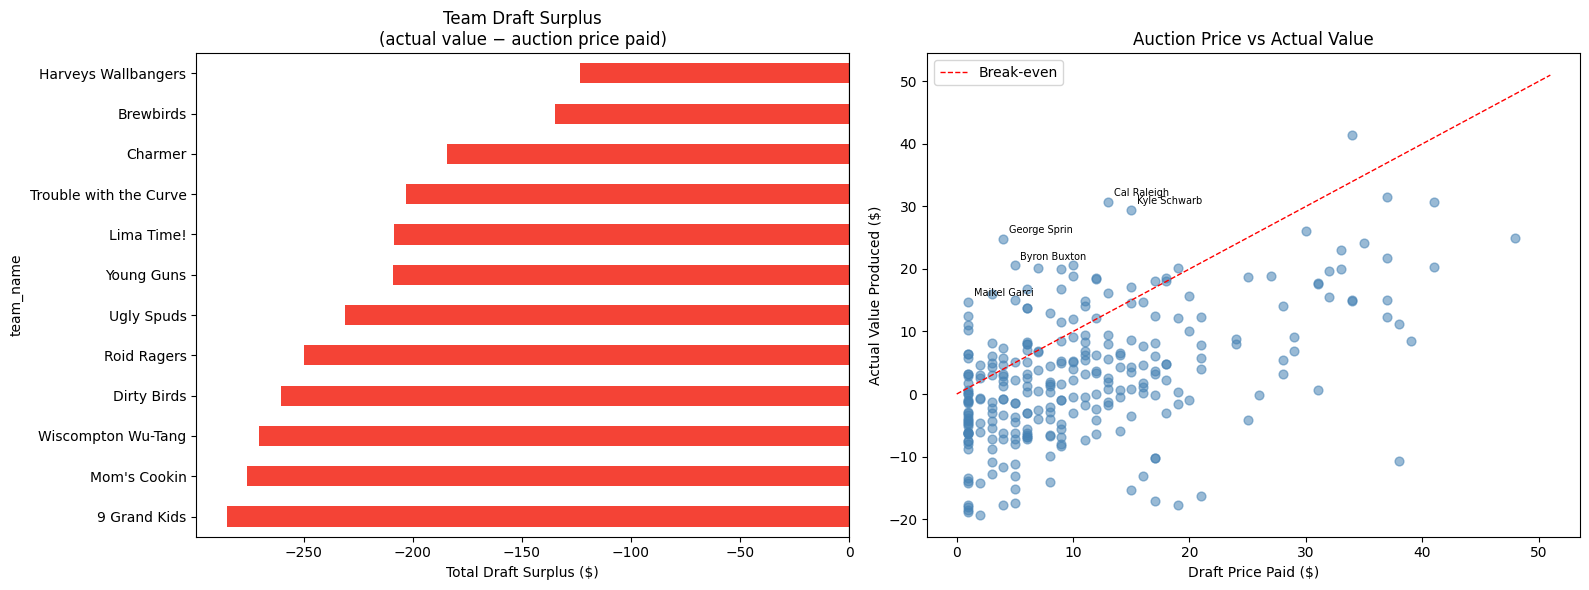

In [17]:
# ── Charts ────────────────────────────────────────────────────────────────────
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Team surplus bar
ax = axes[0]
ts_sorted = team_draft['surplus'].sort_values()
ts_sorted.plot.barh(ax=ax, color=['#4CAF50' if v >= 0 else '#F44336' for v in ts_sorted])
ax.axvline(0, color='black', linewidth=0.8)
ax.set_xlabel('Total Draft Surplus ($)')
ax.set_title('Team Draft Surplus\n(actual value − auction price paid)')

# Scatter: paid vs actual value per auction player
ax2 = axes[1]
ax2.scatter(auction['Paid'], auction['team_value'], alpha=0.55, s=40, color='steelblue')
lim = max(auction['Paid'].max(), auction['team_value'].max()) + 3
lo  = min(0, auction['team_value'].min()) - 3
ax2.plot([0, lim], [0, lim], 'r--', linewidth=1, label='Break-even')
ax2.set_xlabel('Draft Price Paid ($)')
ax2.set_ylabel('Actual Value Produced ($)')
ax2.set_title('Auction Price vs Actual Value')
ax2.legend()
# Label top surpluses
for _, r in auction.nlargest(5, 'surplus').iterrows():
    ax2.annotate(r['Name'][:12], (r['Paid'], r['team_value']),
                 fontsize=7, xytext=(4, 4), textcoords='offset points')

plt.tight_layout()
plt.show()

In [18]:
conn.close()
print("Analysis complete.")

Analysis complete.
